In [1]:
# Basics
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets
import numpy as np
import cv2
import copy
# Adding noise
from skimage.util import random_noise
from torchvision.utils import save_image
from torch.utils.data import DataLoader

# For CNN
import torch.nn as nn
import torch.nn.functional as F

# For Loss Func. And Optimization
import torch.optim as optim

# For Visual Representation
import matplotlib.pyplot as plt

# In case defined class doesn't work, create new dataset from this
from torchvision.datasets import ImageFolder as img_fold

print("Success")


Success


In [219]:
EPOCHS = 20
TRAIN_NOISE = True
TEST_NOISE = False
BATCH_SIZE = 5
NUM_CLASSES = 10

transformer = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [125]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Run if using normal CIFAR

# Data Downloading
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transformer)

# Data Loader
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Image Categories
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck') 

Files already downloaded and verified


In [126]:
# Setting root directory for training data
trainroot = "./Noiseimg/train"
testroot = "./Noiseimg/test"
# Using ImageFolder to designate and transform our entire dataset (determine if necessary to transform here and in dataloaders)
trainset = img_fold(root=trainroot, transform=transformer)
testset = img_fold(root=testroot, transform=transformer)

In [127]:
# grabbing labels
class_names = trainset.classes
print('Labels: ',class_names)
print('Trainset Length: ', len(trainset))
print('Testset Length: ', len(testset))

Labels:  ['bird', 'car', 'cat', 'deer', 'dog', 'frog', 'horse', 'plane', 'ship', 'truck']
Trainset Length:  1000
Testset Length:  100


In [128]:
# Storing tensors for images and labels
img, label = trainset[0][0], trainset[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.4196, -0.5608],
         [-1.0000, -0.5608, -1.0000,  ..., -1.0000, -1.0000,  0.0902],
         [-1.0000, -0.9922, -1.0000,  ..., -0.9843, -1.0000, -0.5765],
         ...,
         [-0.8588,  0.4510, -0.4980,  ..., -1.0000, -0.7176, -0.9608],
         [-0.6235, -1.0000, -0.3569,  ..., -0.3569, -0.3490, -0.1843],
         [-0.7333, -0.2549, -0.9608,  ..., -0.3020, -1.0000, -0.3255]],

        [[-1.0000, -1.0000, -1.0000,  ..., -0.3569, -0.7569, -0.6000],
         [-1.0000, -0.9373, -1.0000,  ..., -1.0000, -1.0000, -0.8431],
         [-1.0000, -1.0000, -1.0000,  ..., -0.3804, -0.4510, -0.7333],
         ...,
         [-1.0000, -0.2471, -0.5373,  ..., -0.8824, -0.4196, -0.1686],
         [-0.6392, -0.2706, -0.3176,  ..., -0.4902, -1.0000,  0.1608],
         [-0.7882,  0.1843, -1.0000,  ..., -0.6235, -0.2863, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.2941],
         [-1.0000, -1.0000, -1.

In [ ]:
# Custom dataset created, proceed training like normal
# Consider creating a way to check number of pictures in a folder; designate number of photos per class folder -> fill each class folder until number is met | Consider using the length function to get the length of the folder
# Modify to use as a general template

In [152]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)

testloader =torch.utils.data.DataLoader(testset, batch_size = BATCH_SIZE,
                                            shuffle=True, num_workers=2)

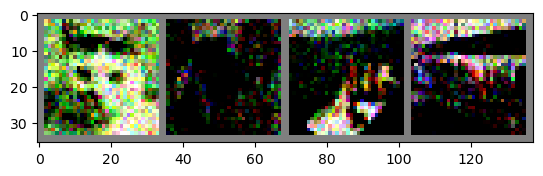

cat   bird  ship  plane


In [153]:
# Show image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# Randomly selected training img
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{trainset.classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

In [154]:
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {labels.shape}")

Image shape: torch.Size([3, 32, 32]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([4])


In [220]:
class Net(nn.Module):
    
    # Defining a network
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5) #Change argument 2 to experiment, must match argument 1 of conv 2
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 16, 5) #Change argument 1 to experiment, must match argument 2 of conv 1
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    # Defining forward pass
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [196]:
# Setting up loss func. and optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = .01, momentum=0.9)

In [221]:
# Setting up CUDA Device
if torch.cuda.is_available():
    print("Available")
    device = torch.device("cuda")
    net.cuda()
    print("")
    
# Setup train loss and train accuracy values
train_loss, train_acc = 0, 0
    
# Loop through data loader data batches
for epoch in range(EPOCHS):
    for batch, (X, y) in enumerate(trainloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = net(X)

        # 2. Calculate  and accumulate loss
        loss = criterion(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
        # print('Train loss: ', train_loss,' ', 'Train Acc: ',train_acc)

# Adjust metrics to get average loss and accuracy per batch 
train_loss = train_loss / len(trainloader)
train_acc = train_acc / len(trainloader)
print('Final Train loss: ', train_loss,' ', 'Final Train Acc: ',train_acc)

Available

Final Train loss:  46.11253053665161   Final Train Acc:  2.0


In [208]:
PATH = './cifar_net_gauss.pth'
torch.save(net.state_dict(), PATH)

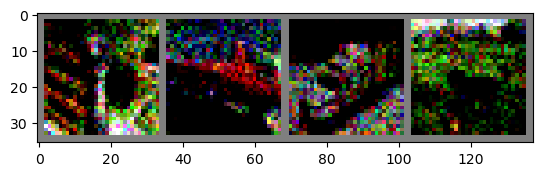

Truth:  bird  car   truck dog  


In [215]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# show img from test set
imshow(torchvision.utils.make_grid(images))
print('Truth: ', ' '.join(f'{testset.classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

In [217]:
# loading saved model
net = Net()
net.load_state_dict(torch.load('./cifar_net_gauss.pth'))

# Testing against above images
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{testset.classes[predicted[j]]:5s}'
                              for j in range(BATCH_SIZE)))

Predicted:  dog   cat   cat   dog  


In [164]:
# Now test on entire dataset
correct = 0 
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        
        # Pick class with highest similarity score
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 20 %


In [165]:
# Breakdown
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 60.0 %
Accuracy for class: deer  is 40.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 40.0 %
Accuracy for class: horse is 10.0 %
Accuracy for class: ship  is 30.0 %
Accuracy for class: truck is 20.0 %
